In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch
import PIL.Image
import os
import seaborn as sbn
from albumentations import GaussNoise, RandomGridShuffle, Normalize, PixelDropout

sbn.set()

datadir = "EM_ISBI_CHALLENGE"

In [5]:
# Make dataset class.
class ChallengeData(torch.utils.data.Dataset):
    '''  Dataset which loads all images for training or testing'''
    def __init__(self, data_dir, nr_im, train_set, margin_size=20):
        self.images = []
        self.labels = []

        self.train_set = train_set
  
        normalizer = Normalize(mean=(0.5), std=(0.5))

        img_prefix = 'train' if train_set else 'test'
        img_folder = 'train_images' if train_set else 'test_images'
        labels_folder = 'train_labels'
        labels_prefix = 'labels'

        for idx in range(1, nr_im + 1):
            im = np.array(PIL.Image.open(f'{data_dir}/{img_folder}/{img_prefix}_{idx:02d}.png'))
            # im = im/255
            im = normalizer.apply(image=im, p=1)
            self.images.append(torch.tensor(im[:256,:256], dtype=torch.float32))
            self.images.append(torch.tensor(im[256:,:256], dtype=torch.float32))
            self.images.append(torch.tensor(im[:256,256:], dtype=torch.float32))
            self.images.append(torch.tensor(im[256:,256:], dtype=torch.float32))
            # Divide into iamges of size 128x128

            if train_set:
                label_im = np.array(PIL.Image.open(f'{data_dir}/{labels_folder}/{labels_prefix}_{idx:02d}.png'))
                label_im = label_im/255
                # label_im = label_im[margin_size:-margin_size, margin_size:-margin_size]/255
                self.labels.append(torch.tensor(label_im[:256,:256], dtype=torch.int64))
                self.labels.append(torch.tensor(label_im[256:,:256], dtype=torch.int64))
                self.labels.append(torch.tensor(label_im[:256,256:], dtype=torch.int64))
                self.labels.append(torch.tensor(label_im[256:,256:], dtype=torch.int64))

    def __getitem__(self, idx):
        if self.train_set:
            return self.images[idx], self.labels[idx]
        
        return self.images[idx]
    
    def __len__(self):
        return len(self.images)

In [6]:
# Make training and validation set.
# (This involves loading images and may take some seconds.)

challengeTrainData = ChallengeData(datadir, 30, True)
challengeTestData = ChallengeData(datadir, 30, False)


In [7]:
trainloader = torch.utils.data.DataLoader(challengeTrainData,
                                          batch_size=10,
                                          shuffle=True,
                                          drop_last=True)
testloader = torch.utils.data.DataLoader(challengeTestData,
                                          batch_size=20)

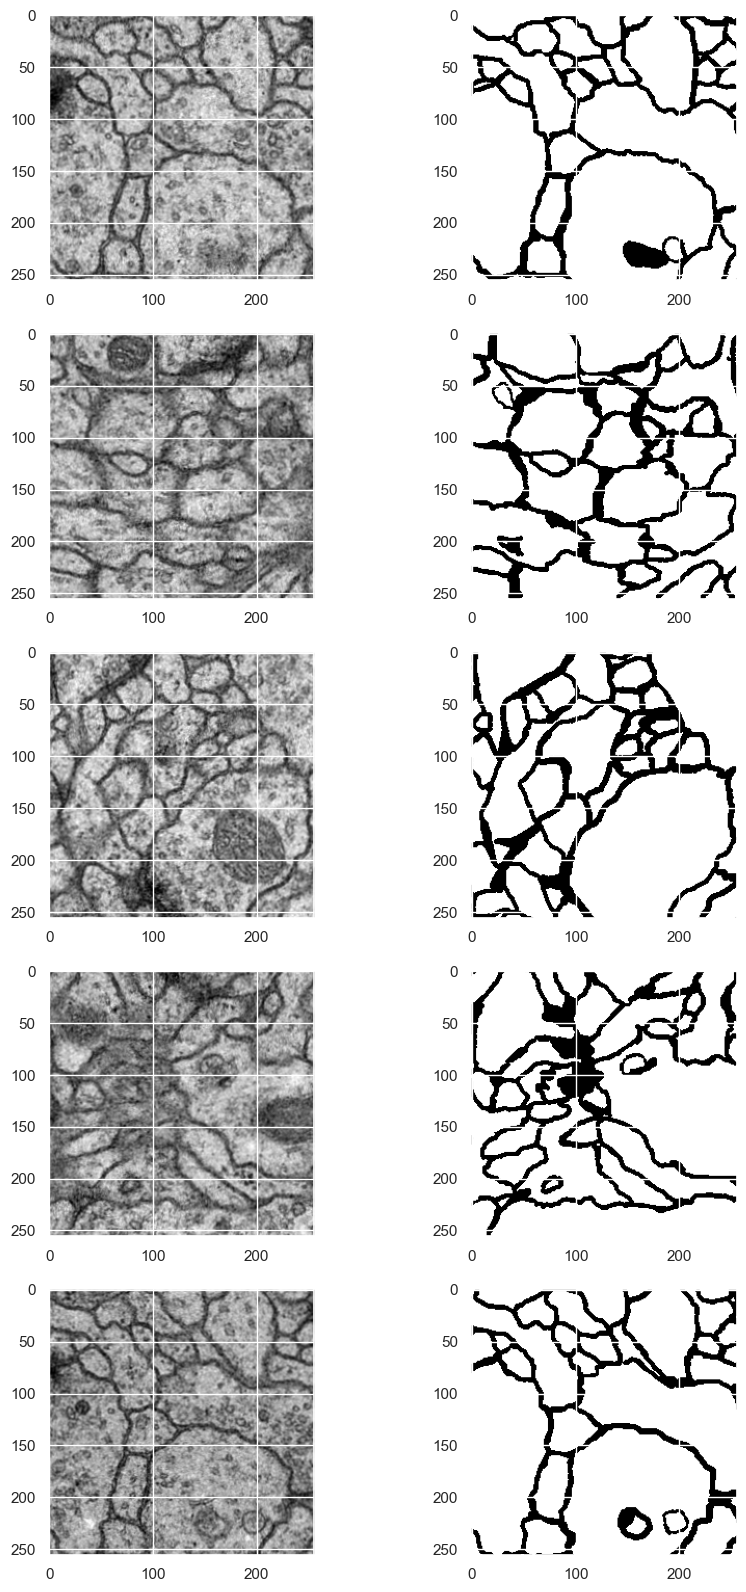

In [8]:
# Plot the first 5 images and labels in the train set
fig, ax = plt.subplots(5, 2, figsize=(10, 20))
for i in range(5):
    ax[i, 0].imshow(challengeTrainData[i][0], cmap='gray')
    ax[i, 1].imshow(challengeTrainData[i][1], cmap='gray')
plt.show()

In [9]:
# Create convolutional network taking size 256x256 as input and outputting size 256x256.
# The network should have 3 convolutional layers with 3x3 kernels and 1x1 stride.
# The first two layers should have 16 output channels, the last one should have 2 output channels.
# The first two layers should have ReLU activation, the last one should have no activation.
# The network should have a final softmax layer.

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 16, 3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(16, 16, 3, stride=1, padding=1)
        self.conv3 = torch.nn.Conv2d(16, 2, 3, stride=1, padding=1)
        self.softmax = torch.nn.Softmax(dim=1)
        self.relu = torch.nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return self.softmax(x)


In [10]:
epochs = 20
loss_function = torch.nn.CrossEntropyLoss()
net = Net()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

epoch_train_losses = []

In [11]:
# Train the network
for e in range(epochs):
    train_losses = []
    for batch in trainloader:
        optimizer.zero_grad()
        output = net(batch[0].unsqueeze(1))
        loss = loss_function(output, batch[1])
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    epoch_train_losses.append(np.mean(train_losses))

    print(f'Epoch {e+1}/{epochs} | Train loss: {epoch_train_losses[-1]:.6f}')

Epoch 1/20 | Train loss: 0.672690
Epoch 2/20 | Train loss: 0.589347
Epoch 3/20 | Train loss: 0.505758
Epoch 4/20 | Train loss: 0.477733
Epoch 5/20 | Train loss: 0.472694
Epoch 6/20 | Train loss: 0.471064
Epoch 7/20 | Train loss: 0.470667
Epoch 8/20 | Train loss: 0.469947
Epoch 9/20 | Train loss: 0.469445
Epoch 10/20 | Train loss: 0.469210
Epoch 11/20 | Train loss: 0.469054
Epoch 12/20 | Train loss: 0.468749
Epoch 13/20 | Train loss: 0.468462
Epoch 14/20 | Train loss: 0.468254
Epoch 15/20 | Train loss: 0.468015
Epoch 16/20 | Train loss: 0.467951
Epoch 17/20 | Train loss: 0.467788
Epoch 18/20 | Train loss: 0.467850
Epoch 19/20 | Train loss: 0.467697
Epoch 20/20 | Train loss: 0.468174


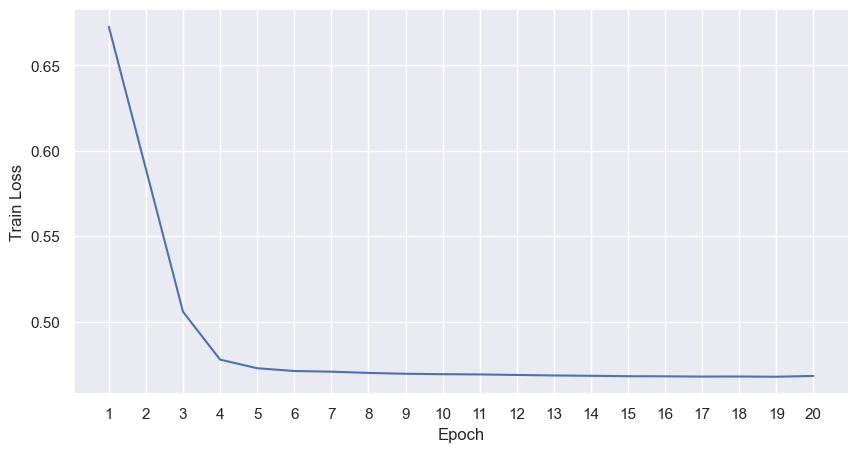

In [20]:
# Plot the train loss
fig, ax = plt.subplots(1, figsize=(10, 5))
ax.plot(np.arange(1, epochs + 1, 1), epoch_train_losses)
ax.set_xlabel('Epoch')
ax.set_xticks(np.arange(1, epochs + 1, 1))
ax.set_ylabel('Train Loss')
plt.show()

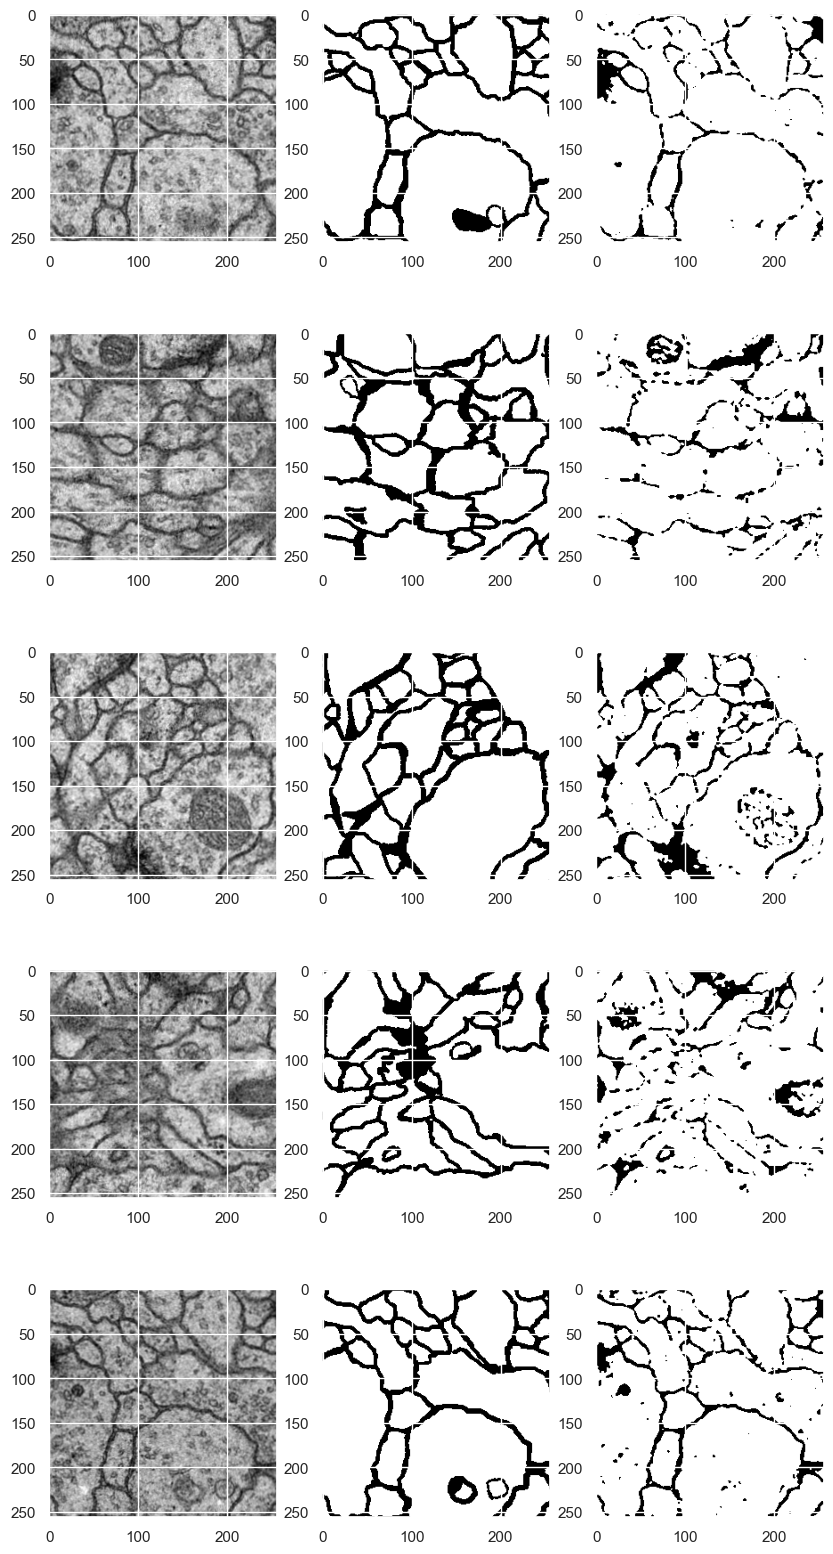

In [21]:
# Visualize train predictions
fig, ax = plt.subplots(5, 3, figsize=(10, 20))
for i in range(5):
    ax[i, 0].imshow(challengeTrainData[i][0], cmap='gray', label='Input')
    ax[i, 1].imshow(challengeTrainData[i][1], cmap='gray', label='Ground truth')
    ax[i, 2].imshow(torch.argmax(net(challengeTrainData[i][0].unsqueeze(0).unsqueeze(0)), dim=1)[0], cmap='gray', label='Prediction')


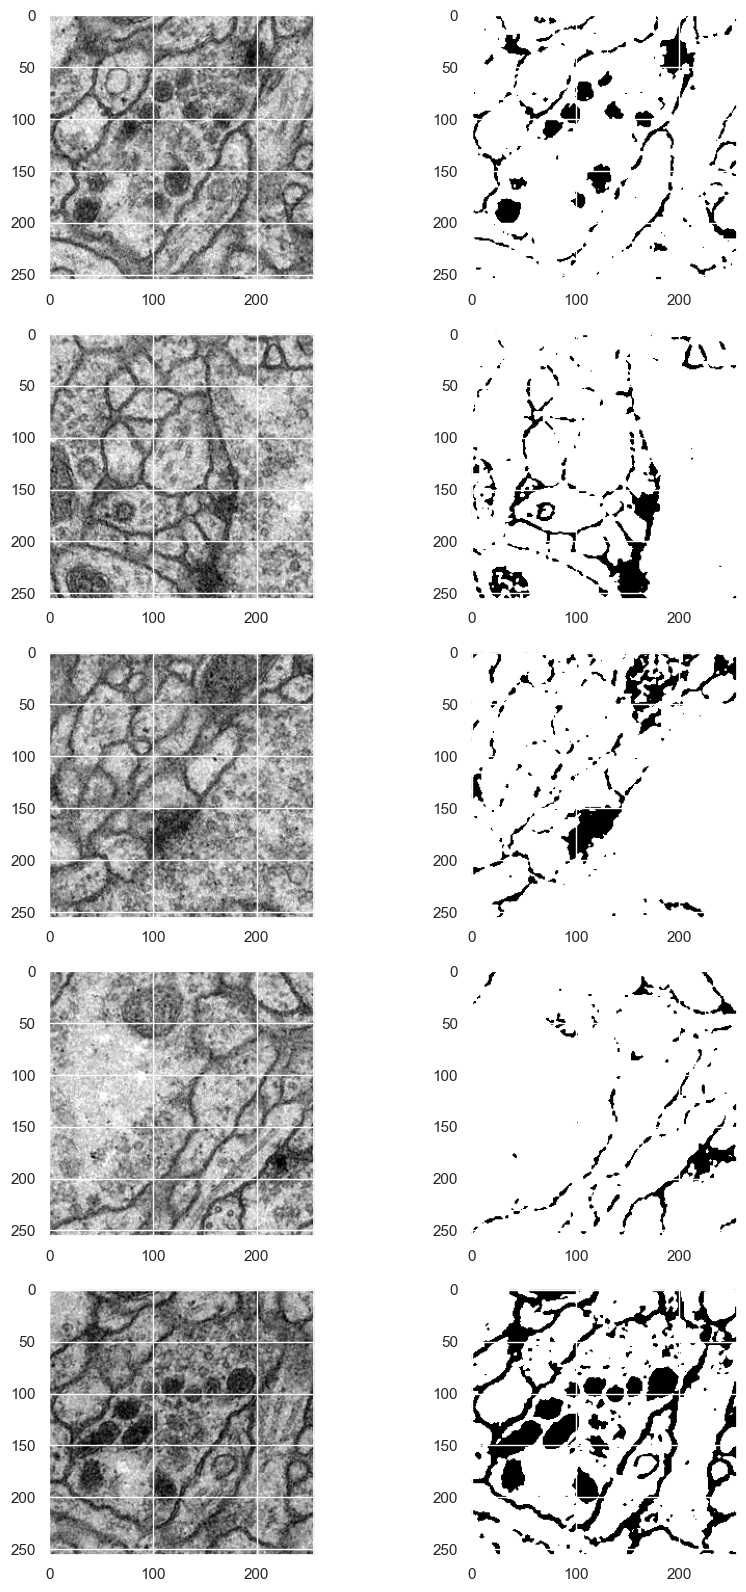

In [22]:
# Visualize test predictions
fig, ax = plt.subplots(5, 2, figsize=(10, 20))
for i in range(5):
    ax[i, 0].imshow(challengeTestData[i], cmap='gray', label='Input image')
    ax[i, 1].imshow(torch.argmax(net(challengeTestData[i].unsqueeze(0).unsqueeze(0)), dim=1)[0], cmap='gray', label='Prediction')

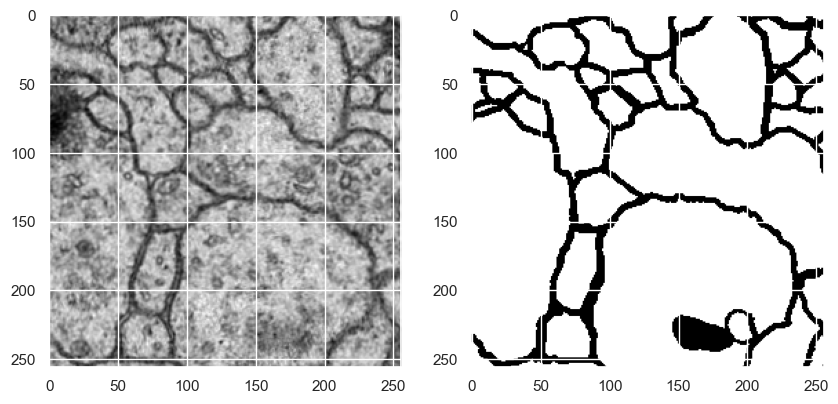

In [23]:
img = challengeTrainData[0][0]
lbl = challengeTrainData[0][1]
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img, cmap='gray')
ax[1].imshow(lbl, cmap='gray')
plt.show()

# Data augmentation

In [16]:
from scipy.ndimage import gaussian_filter, map_coordinates

In [17]:
# Apply Random Elastic Deformation
# (This involves loading images and may take some seconds.)

def random_elastic_deformation(image, label, alpha, sigma):
    random_state = np.random.RandomState(None)
    shape = image.shape

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha

    x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')
    indices = np.reshape(x+dx, (-1, 1)), np.reshape(y+dy, (-1, 1))
    img_augmented = map_coordinates(image, indices, order=1).reshape(shape)
    lbl_augmented = map_coordinates(label, indices, order=1).reshape(shape)
    return img_augmented, lbl_augmented

In [25]:
img = challengeTrainData[0][0].numpy()
lbl = challengeTrainData[0][1].numpy()

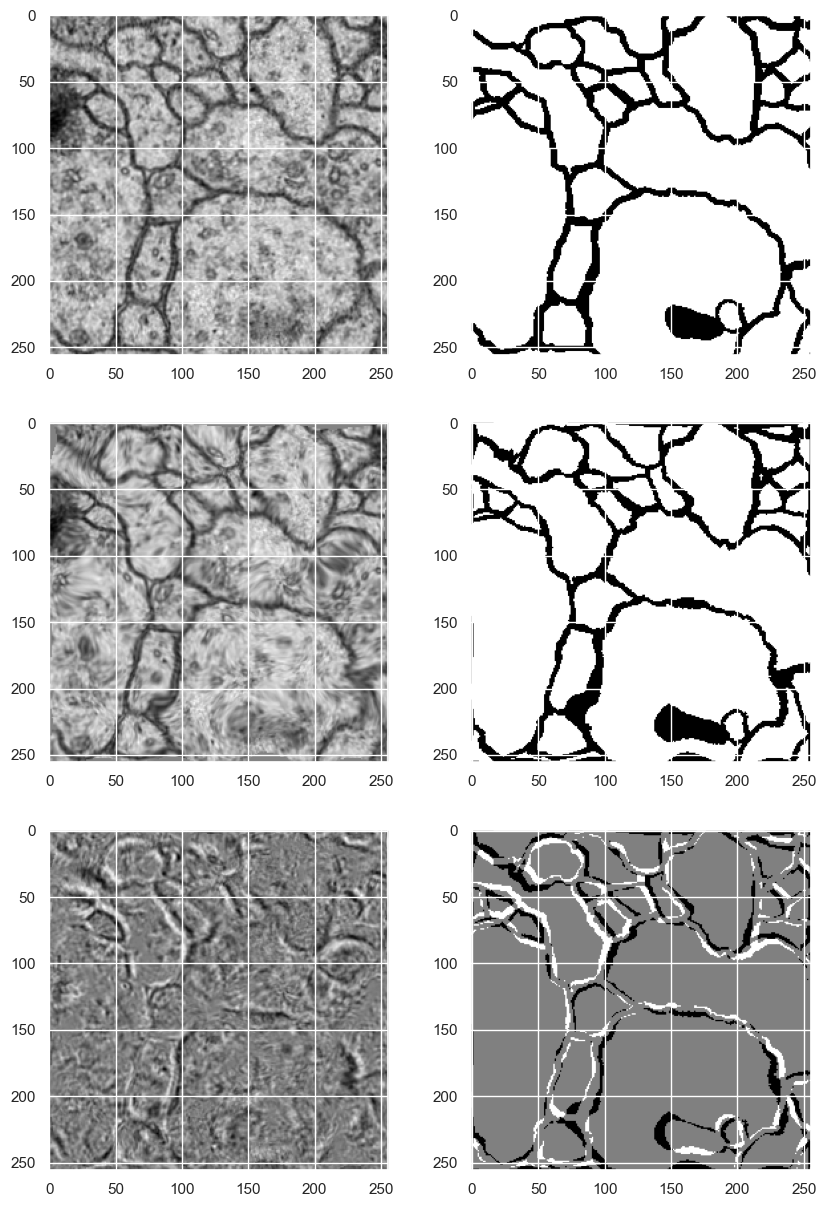

In [31]:
img_augmented, lbl_augmented = random_elastic_deformation(img, lbl, 200, 10)
fig, ax = plt.subplots(3, 2, figsize=(10, 15))
ax[0, 0].imshow(img, cmap='gray')
ax[0, 1].imshow(lbl, cmap='gray')
ax[1, 0].imshow(img_augmented, cmap='gray')
ax[1, 1].imshow(lbl_augmented, cmap='gray')
ax[2, 0].imshow(img_augmented - img, cmap='gray')
ax[2, 1].imshow(lbl_augmented - lbl, cmap='gray')
plt.show()